## Cellpose - Transfer learning (Intelligent)

Apply the anatomical segmentation algorithm [cellpose](https://www.cellpose.org/) to the data

In [1]:
#!pip install cellpose

# Imports

In [2]:
from cellpose import models, plot, io, metrics
from yacs.config import CfgNode as CN 
import os
import h5py
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import zoom
import tifffile
from scipy import optimize
import cv2
from tqdm import tqdm

from connectomics.data.utils import *
from connectomics.data.utils import getSegType
from skimage.transform import resize

2022-02-28 23:46:52,278 [INFO] WRITING LOG OUTPUT TO /n/home05/lauenburg/.cellpose/run.log


# Configs

In [3]:
_C = CN()

# path to the datasets
_C.ROOT = "/n/pfister_lab2/Lab/zudilin/data/NucExM/NucExM-Release"
# datasets
#_C.VOLUMES = ["image0.h5","image1.h5","image2.h5","image3.h5"]
_C.VOLUMES = ["image4.h5"]

_C.H5KEY = 'main'

In [4]:
def get_cfg_defaults():
    return _C.clone()

cfg = get_cfg_defaults()

# Best configs:
* "image0.h5" : vol, stitch_threshold=0.7, do_3D=False, resample=True, anisotropy=5, flow_threshold=1.2, mask_threshold=-3, diameter=70, invert=False
* "image1.h5" : 
* "image2.h5" : 
* "image3.h5" : 


# Utils

In [5]:
# taken from PyCT (author: Zudi Lin)
def cast2dtype(segm):
    """Cast the segmentation mask to the best dtype to save storage.
    """
    max_id = np.amax(np.unique(segm))
    m_type = getSegType(int(max_id))
    return segm.astype(m_type)

In [6]:
# load h5 volume
def load_vol(root,vol_name):
    """ Loads and returns the data from an h5 file
        
        Args:
            root: path to the root folder
            vol_name: name of the volume
            
        Return:
            The loaded volume as numpy array
    """
    with h5py.File(os.path.join(root, vol_name), 'r') as h5:
        vol = np.asarray(h5.get(cfg.H5KEY))
    return vol

In [7]:
# load tif volume
def load_vol_tif(path):
    """ Loads and returns the data from an tif file
        
        Args:
            root: path to the root folder
            vol_name: name of the volume
            
        Return:
            The loaded volume as numpy array
    """
    with tifffile.TiffFile(path) as tif:
        vol = np.asarray([img.asarray()  for img in tif.pages[:]])
    return vol

In [8]:
# plot sample result
def vis_sample(img, masks, flows, channels=[[0,0]], figsize=(12,5), save=False, path=None):
    """ Visualizes the output of the Cellpose algorithems.
    
        Args:
            img: the orginal image
            mask: the mask outputed by Cellpose
            flow: the flows outputed by Cellpose
    """
    fig = plt.figure(figsize=figsize)
    plot.show_segmentation(fig, img, masks, np.asarray(flows[0]), channels=channels)
    plt.tight_layout()
    plt.show()
    if save:
        fig.savefig(path, dpi=fig.dpi)

In [9]:
def color_grid_box(img,block_size,x1,x2,y1,y2,color=[255,0,0]):
    """ Creates adds the outline of a square to a image with three channels.
    
        Args:
            img: the image in which to draw the outline
            block_size: the size of the square
            x1: the location of the left vertical edge
            x2: the location of the right vertical edge
            y1: the location of the top horizontal edge
            y2: the location of the bottom horizontal edge            
    """
    if not isinstance(block_size, tuple):
        if isinstance(block_size, int):
            block_size= (block_size,block_size)
        else:
            print(f"block_size must be tupel or int, but is {block_size.type}")
    img[y1*block_size[0]:y2*block_size[0],x1*block_size[1],:] = grid_color_red
    img[y1*block_size[0]:y2*block_size[0],x2*block_size[1],:] = grid_color_red
    img[y1*block_size[0],x1*block_size[1]:x2*block_size[1],:] = grid_color_red
    img[y2*block_size[0],x1*block_size[1]:x2*block_size[1],:] = grid_color_red
    return img

# Cellpose model

In [10]:
model = models.Cellpose(model_type='nuclei', gpu=True)
# gray images
channels = [[0,0]]

2022-02-28 23:47:04,437 [INFO] ** TORCH CUDA version installed and working. **
2022-02-28 23:47:04,441 [INFO] >>>> using GPU


# Inference full volume

In [11]:
#setup model
model = models.Cellpose(model_type='nuclei', gpu=True)

# define channels - gray images
channels = [[0,0]]

for l, vol_name in enumerate(cfg.VOLUMES):
    # laod volume 
    vol = load_vol(cfg.ROOT, vol_name)
    assert(vol.shape==(255,2048,2048)),f"{vol.shape}"
    
    # inference volume 
    masks, flows, styles, diams = model.eval(vol, stitch_threshold=0.7, do_3D=False, resample=True, anisotropy=5, flow_threshold=1.2, mask_threshold=-3, diameter=70, invert=False)
    
    # resize masks
    masks_resize = resize(masks, (255,512,512), order=0, preserve_range=True, anti_aliasing=False)
    assert(masks_resize.shape==(255,512,512)),f"{masks_resize.shape}"

    # cast type to int
    final_mask_volume = cast2dtype(masks_resize)
    assert(final_mask_volume.dtype in ["uint16", "uint32", "uint64"]), "The input label volume should be of type uint8 | uint16 | uint32 | uint64"

    # save to file
    with h5py.File(os.path.join("/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/cellpose_ouput", "cellpose_no3d_stitch_2_"+vol_name), "w") as h5:
        h5_dataset =  h5.create_dataset("main", data=final_mask_volume)
    

2022-02-28 23:47:04,580 [INFO] ** TORCH CUDA version installed and working. **
2022-02-28 23:47:04,581 [INFO] >>>> using GPU
2022-02-28 23:47:13,503 [INFO] ~~~ FINDING MASKS ~~~
2022-02-28 23:47:13,507 [INFO] multi-stack tiff read in as having 255 planes 1 channels
2022-02-28 23:48:47,217 [INFO] 39%|###9      | 100/255 [01:27<02:13,  1.16it/s]


2022-02-28 23:50:15,504 [INFO] 80%|#######9  | 203/255 [02:56<00:43,  1.19it/s]


2022-02-28 23:50:59,367 [INFO] 100%|##########| 255/255 [03:40<00:00,  1.16it/s]
2022-02-28 23:50:59,506 [INFO] network run in 220.25s
2022-03-01 00:12:29,766 [INFO] stitching 255 planes using stitch_threshold=0.700 to make 3D masks
2022-03-01 00:12:56,752 [INFO] masks created in 1317.24s
2022-03-01 00:14:46,173 [INFO] >>>> TOTAL TIME 1652.67 sec


# Inference slice by slice

In [19]:
# values derived from experimenting with the sample below
diamters = [110,100,100,100]
thresholds = [-1,-2,-2,-2]

In [1]:
for i, vol_name in enumerate(cfg.VOLUMES[:1]):
    vol = load_vol(cfg.ROOT, vol_name)
    
    final_mask_volume = np.zeros((255,512,512))
    
    for i, v in enumerate(vol):
        m, flows, styles, diams = model.eval(v, resample=True, anisotropy=1, flow_threshold=1.2, mask_threshold=-5, diameter=60, invert=False, channels=channels)
        m = resize(m, (512,512), order=0, preserve_range=True, anti_aliasing=False)

        final_mask_volume[i,:,:] = m

    final_mask_volume = cast2dtype(final_mask_volume)
    final_mask_volume = stitch3D(final_mask_volume)

    with h5py.File(os.path.join("/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/cellpose_ouput", "cellpose_masks_img_by_img_care_"+vol_name), "w") as h5:
        h5_dataset =  h5.create_dataset("main", data=final_mask_volume)
    

NameError: name 'cfg' is not defined

# Load and inspect results

In [16]:
with h5py.File(os.path.join("/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/cellpose_ouput", "cellpose_no3d_stitch_2_"+vol_name), "r") as h5:
    h5_dataset =  np.asarray(h5.get('main'))

In [18]:
print(os.path.join("/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/cellpose_ouput", "cellpose_no3d_stitch_2_"+vol_name))

/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/cellpose_ouput/cellpose_no3d_stitch_2_image4.h5


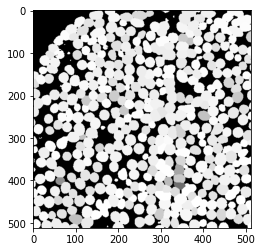

In [17]:
plt.set_cmap("gray")
plt.imshow(h5_dataset[100,:,:])

# Grid search

In [ ]:
label = "/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/gt_seg_mask/seg_3D_255_512_512.tif"
images = "/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/testA/em_3D_255_512_512.tif"
img = load_vol_tif(images)
lab = load_vol_tif(label)

print(img.shape)
print(lab.shape)
for i, vol_name in enumerate(cfg.VOLUMES):
    params = (load_vol_tif(images)[120:180,:512,:512], load_vol_tif(label)[120:180,:512,:512], model)
    rranges = (slice(1, 4, 1), slice(90, 120, 5), slice(-3, 3, 1))
    resbrute = optimize.brute(grid_search_stardis, rranges, args=params, full_output=True,
                          finish=optimize.fmin)

print(resbrute)

# Manual grid search

In [ ]:
diamters = [110,120]
flow = [0.8, 1.0]
threshold = [-4, -3, -2, -1]
for vol in cfg.VOLUMES[2:]:
    vol = load_vol(cfg.ROOT, vol)
    img0_100 = vol_norm[100, : , :]
    for d in diamters:
        for f in flow:
            for t in threshold:
                print(f"Diameter {d}, flow {f}, tresh {t}")
                masks, flows, styles, diams = model.eval(img0_100, resample=True, anisotropy=3, flow_threshold=f, mask_threshold=t, diameter=d, invert=True, channels=channels)
                vis_sample(img0_100, masks, flows)#, save=True, path=os.path.join("/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/cellpose_ouput", vol.split(".")[0]+"_d_"+str(d)+"_t_"+ str(t)+".png"))

# Estimate cell size in pixel

In [ ]:
# retrive sample image
img = np.asarray(vol[100, : , :]).astype(np.uint8)
print(img.shape)

# stack to three channels
img = np.stack((img,)*3, axis=-1)

# estimate cell size
BLOCKSIZE = (95,95)

# grid lines at these intervals (in pixels)
dx, dy = BLOCKSIZE
    
# divide the image shape in to tiles
ys = int(img.shape[0] // dy)
xs = int(img.shape[1] // dx)    

# setup the ticks and labels for the x axis
x_ticks = [BLOCKSIZE[1]*i for i in range (0,xs)]
x_labels = [i for i in range (0,xs)]

# setup the ticks and labels for the y axis
y_ticks = [BLOCKSIZE[0]*i for i in range (0,ys)]
y_labels = [i for i in range (0,ys)]

# colors
grid_color_green = [0,100,0]
grid_color_red = [255,0,0]

# Modify the image to include the grid
img[:,::dy,:] = grid_color_green
img[::dx,:,:] = grid_color_green

# color in sample cells
img = color_grid_box(img,BLOCKSIZE,10,11,12,13,color=grid_color_red)
img = color_grid_box(img,BLOCKSIZE,13,14,16,17,color=grid_color_red)
img = color_grid_box(img,BLOCKSIZE,14,15,19,20,color=grid_color_red)
img = color_grid_box(img,BLOCKSIZE,4,5,8,9,color=grid_color_red)

fig, axes = plt.subplots(ncols=1,nrows=1, figsize=(20,20))

axes.set_xticks(x_ticks)
axes.set_xticklabels(x_labels)
axes.set_yticks(y_ticks)
axes.set_yticklabels(y_labels) 
axes.imshow(img)
